# Nota

Reiniciar Jupyter antes de correr este notebook

In [1]:
import findspark
findspark.init('/spark-3.5.1-bin-hadoop3')
from pyspark import *
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType
from pyspark.sql.functions import col


spark = SparkSession.builder.appName("analytics").config("spark.driver.memory", "4g").getOrCreate()

24/07/25 14:52:37 WARN Utils: Your hostname, Joses-MacBook-Air-2.local resolves to a loopback address: 127.0.0.1; using 192.168.100.124 instead (on interface en0)
24/07/25 14:52:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/25 14:52:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# MNIST Classifier

Ejemplo que muestra como clasificar dígitos escritos a mano con el Multilayer Perceptron Classifier (MLPC) y el conjunto de datos MNIST.

Los datos de MNIST puede obtenerse de [http://yann.lecun.com/exdb/mnist/](http://yann.lecun.com/exdb/mnist/) y consisten en los siguientes archivos:

* train-images-idx3-ubyte.gz: Imagenes de entrenamiento
* train-labels-idx1-ubyte.gz: Etiquetas de entrenamiento
* t10k-images-idx3-ubyte.gz: Imagenes de prueba
* t10k-labels-idx1-ubyte.gz: Etiquetas de prueba

Para poder ejecutar este ejemplo, extraiga los archivos en el directorio `data/` bajo donde se ejecutó este archivo.

## Cargar los datos de MNIST

In [2]:
# Función para cargar y convertir los datos MNIST
def load_mnist_data(path, is_train=True):
    # El archivo de imagenes y etiquetas
    img_file = 'train-images-idx3-ubyte' if is_train else 't10k-images-idx3-ubyte'
    lbl_file = 'train-labels-idx1-ubyte' if is_train else 't10k-labels-idx1-ubyte'
    
    # Cargar imagenes
    with open(f'{path}/{img_file}', 'rb') as f:
        images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28*28).astype(float)
    
    # Cargar etiquetas
    with open(f'{path}/{lbl_file}', 'rb') as f:
        labels = np.frombuffer(f.read(), np.uint8, offset=8).astype(int)
    
    return images, labels

# Ruta a los archivos MNIST
path = 'data'

# Cargar los datos de entrenamiento y prueba
train_images, train_labels = load_mnist_data(path, is_train=True)
test_images, test_labels = load_mnist_data(path, is_train=False)

## Dataframes:

Crear Dataframes para poder distribuir el procesamiento

Los datos del conjunto de datos MNIST se cargan desde archivos binarios utilizando `NumPy`. Los datos de las imágenes y etiquetas se leen y se convierten a tipos de datos `float` e `int` respectivamente. Luego, los datos de las imágenes y etiquetas se combinan en tuplas, y se define un esquema explícito para el `DataFrame` de Spark con campos de tipo `FloatType` para los píxeles e `IntegerType` para las etiquetas. 

In [3]:
# Definir el esquema para los DataFrames
schema = StructType([StructField("pixel" + str(i), FloatType(), False) for i in range(28*28)] + [StructField("label", IntegerType(), False)])

# Crear un DataFrame de Spark a partir de los datos de entrenamiento
train_data = [tuple(x.tolist()) + (int(y),) for x, y in zip(train_images, train_labels)]
train_df = spark.createDataFrame(train_data, schema=schema)

# Crear un DataFrame de Spark a partir de los datos de prueba
test_data = [tuple(x.tolist()) + (int(y),) for x, y in zip(test_images, test_labels)]
test_df = spark.createDataFrame(test_data, schema=schema)


## Preparar las características

In [4]:
# Ensamblar todas las características en un solo vector
assembler = VectorAssembler(
    inputCols=["pixel" + str(i) for i in range(28*28)],
    outputCol="features"
)

train_df = assembler.transform(train_df).select('features', 'label')
test_df = assembler.transform(test_df).select('features', 'label')

## Definir la estructura de la red neuronal

Para configurar la red neuronal, primero se define la estructura de la red especificando el número de neuronas en cada capa. En este caso, la red consta de cuatro capas: una capa de entrada con 784 neuronas (correspondiente a los 28x28 píxeles de las imágenes MNIST), dos capas ocultas con 128 y 64 neuronas respectivamente (seleccionadas aleatoriamente), y una capa de salida con 10 neuronas (correspondiente a las 10 posibles clases de dígitos).

In [5]:
# Definir la estructura de la red neuronal
layers = [28*28, 128, 64, 10]

## Crear el MLPC

El `MultilayerPerceptronClassifier` de PySpark MLlib se configura especificando varios parámetros clave: 

* `maxIter` para definir el número máximo de iteraciones del algoritmo
* `layers` para definir la estructura de la red neuronal
* `blockSize` para establecer el tamaño del bloque de datos en cada iteración
* `seed` para asegurar la reproducibilidad de los resultados (por suspuesto usamos 42 aquí)

In [6]:
# Crear el clasificador de Multilayer Perceptron
mlpc = MultilayerPerceptronClassifier(
    maxIter=100,
    layers=layers,
    blockSize=128,
    seed=42
)

## Entrenar el modelo

In [7]:
# Entrenar el modelo
model = mlpc.fit(train_df)

24/07/25 14:53:29 WARN TaskSetManager: Stage 0 contains a task of very large size (49441 KiB). The maximum recommended task size is 1000 KiB.
24/07/25 14:53:34 WARN TaskSetManager: Stage 1 contains a task of very large size (49441 KiB). The maximum recommended task size is 1000 KiB.
24/07/25 14:53:34 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/07/25 14:53:34 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
24/07/25 14:53:37 WARN TaskSetManager: Stage 3 contains a task of very large size (49441 KiB). The maximum recommended task size is 1000 KiB.
24/07/25 14:53:38 WARN TaskSetManager: Stage 5 contains a task of very large size (49441 KiB). The maximum recommended task size is 1000 KiB.
24/07/25 14:53:40 WARN TaskSetManager: Stage 7 contains a task of very large size (49441 KiB). The maximum recommended task size is 1000 KiB.
24/07/25 14:53:42 WARN TaskSetManager: Stage 9 contains a task of very la

24/07/25 14:54:42 WARN TaskSetManager: Stage 111 contains a task of very large size (49441 KiB). The maximum recommended task size is 1000 KiB.
24/07/25 14:54:43 WARN TaskSetManager: Stage 113 contains a task of very large size (49441 KiB). The maximum recommended task size is 1000 KiB.
24/07/25 14:54:44 WARN TaskSetManager: Stage 115 contains a task of very large size (49441 KiB). The maximum recommended task size is 1000 KiB.
24/07/25 14:54:46 WARN TaskSetManager: Stage 117 contains a task of very large size (49441 KiB). The maximum recommended task size is 1000 KiB.
24/07/25 14:54:47 WARN TaskSetManager: Stage 119 contains a task of very large size (49441 KiB). The maximum recommended task size is 1000 KiB.
24/07/25 14:54:48 WARN TaskSetManager: Stage 121 contains a task of very large size (49441 KiB). The maximum recommended task size is 1000 KiB.
24/07/25 14:54:49 WARN TaskSetManager: Stage 123 contains a task of very large size (49441 KiB). The maximum recommended task size is 10

## Evaluación del modelo

In [8]:
# Hacer predicciones en los datos de prueba
result = model.transform(test_df)

# Evaluar la precisión del modelo
evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

accuracy = evaluator.evaluate(result)
print(f"Precisión del conjunto de prueba = {accuracy:.4f}")

24/07/25 14:55:47 WARN DAGScheduler: Broadcasting large task binary with size 1333.0 KiB
24/07/25 14:55:47 WARN TaskSetManager: Stage 205 contains a task of very large size (7069 KiB). The maximum recommended task size is 1000 KiB.


Precisión del conjunto de prueba = 0.9476


## Resultados

Después de evaluar la precisión del modelo, se seleccionan las predicciones para mostrar ejemplos visuales de cómo el modelo clasifica las imágenes de dígitos. Primero, las características (`features`), etiquetas reales (`label`) y predicciones (`prediction`) se recogen del DataFrame de resultados y se convierten en listas de NumPy para facilitar su manipulación.

Una función llamada display_images se define para mostrar un conjunto de imágenes con sus predicciones correspondientes. Esta función toma como entrada las imágenes, las etiquetas y las predicciones, junto con el número de ejemplos a mostrar. Utiliza `Matplotlib` para crear una figura y subfiguras en un formato de cuadrícula. Cada subfigura muestra una imagen de 28x28 píxeles, con el título que indica la etiqueta real y la predicción del modelo. Para proporcionar una muestra representativa, se seleccionan 25 ejemplos aleatorios del conjunto de datos y se muestran utilizando esta función. Esto permite visualizar de manera clara y comprensible cómo el modelo está funcionando y qué tan precisas son sus predicciones.

24/07/25 14:57:30 WARN DAGScheduler: Broadcasting large task binary with size 1316.3 KiB
24/07/25 14:57:31 WARN TaskSetManager: Stage 209 contains a task of very large size (7069 KiB). The maximum recommended task size is 1000 KiB.


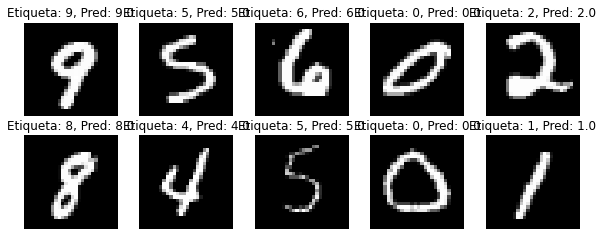

In [11]:
# Mostrar algunas predicciones
predictions = result.select("features", "label", "prediction").collect()

# Mostrar algunas imágenes con sus predicciones
def display_images(images, labels, predictions, num=10):
    plt.figure(figsize=(10, 10))
    for i in range(num):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].reshape((28, 28)), cmap='gray')
        plt.title(f"Etiqueta: {labels[i]}, Pred: {predictions[i]}")
        plt.axis('off')
    plt.show()

# Convertir las características de vuelta a imágenes para visualización
images = np.array([row['features'] for row in predictions])
labels = np.array([row['label'] for row in predictions])
preds = np.array([row['prediction'] for row in predictions])

# Mostrar 5 ejemplos aleatorios de las predicciones
indices = np.random.choice(len(images), 25, replace=False)
display_images(images[indices], labels[indices], preds[indices])

# Referencias:

* [ML Pipelines](https://spark.apache.org/docs/latest/ml-pipeline.html)
* [Learning Spark](https://pages.databricks.com/202003-US-EB-Learning-Spark-2nd-Edition_01_Downloadpage.html) de Jules S. Damji, Brooke Wenig, Tathagata Das & Denny Lee, publicado por O’Reilly
* [Meet the Spark MLlib’s Multilayer Perceptron Classifier (MLPC) — Hands-on
](https://medium.com/analytics-vidhya/spark-mllibs-multilayer-perceptron-classifier-mlpc-hands-on-32ac4014eee9)
* [MultilayerPerceptronClassifier](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.MultilayerPerceptronClassifier.html)
* [PySpark Neural Network from Scratch](https://towardsdatascience.com/pyspark-neural-network-from-scratch-8a19ebad3904)
* [Deep Learning with Apache Spark Part 1](https://towardsdatascience.com/deep-learning-with-apache-spark-part-1-6d397c16abd) & [Deep Learning with Apache Spark Part 2](https://towardsdatascience.com/deep-learning-with-apache-spark-part-2-2a2938a36d35)